In this notebook, we prepare data. The underlying stock price is simulated under the Black-Scholes model. A set of European options is created with the CBOE rule. We then apply some proper filtering on the resulting data. 

In [1]:
import sys
import os
# Append the library path to PYTHONPATH, so library can be imported.
sys.path.append(os.path.dirname(os.getcwd()))
import getpass
import shutil
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pandas.tseries.offsets import BDay
from scipy.stats import norm

from library import bs
from library import plot
from library import vix
from library import common as cm

In [2]:
%run setup.py
%matplotlib inline

# If you want to run this notebook independent of '0_Generate_Data', you need to set RANDOM_SEED by hand.
RANDOM_SEED = 666
np.random.seed(RANDOM_SEED)
sns.set(style='darkgrid')

In [3]:
def make_features(df):
    # Make sure this function is called after copying calls for puts.
    # because delta are different for calls and puts.
    df['tau0_implvol0'] = np.sqrt(df['tau0']) * df['implvol0']
    df['sqrt_tau0'] = np.sqrt(df['tau0'])
    df['1_over_sqrt_tau'] = 1 / np.sqrt(df['tau0'])
    
    # the following three features are used for Hull-White regression.
    df['vega_s'] = df['vega'] / (df['S0_n'] * np.sqrt(df['tau0']))
    df['delta_vega_s'] = df['delta_bs'] * df['vega_s']
    df['delta2_vega_s'] = (df['delta_bs']**2) * df['vega_s']
    
    return df

In [4]:
def creat_vix(x0, start_date, end_date, refresh=False):
    fake_vix = vix.OUprocess(
        'vix',
        x0=x0, 
        sigma=SIGMA,
        kappa=KAPPA,
        mu=MU,
        start_date=start_date,
        end_date=end_date
    )

    vix_path = fake_vix.get_instrument_values_as_df(refresh)
    return vix_path

# Generate train and validation set
We generate a stock path, under the Black-Scholes assumption, where volatility and interest rate are constant. On this path, a set of European option is generated. With this set of options, we construct a dataframe for the use of hedging. This dataframe is then split into a training sete and a validation set.

In the dataframe, we calculate the true option prices by the Black-Scholes formula, and further calculate delta and gamma.

In [6]:
gbm = bs.GeometricBrownianMotion(
    name='gbm', 
    initial_value=INITIAL_INDEX_PRICE,
    volatility=VOLATILITY,
    annual_return=ANNUAL_RETURN,
    start_date=INDEX_START_DATE,
    end_date=INDEX_END_DATE)

In [7]:
options = cm.find_option_seq_jan_cycle(
    gbm, 
    start=OPTION_START_DATE, 
    step_K=STEP_K, 
    threshold=THRESHOLD_OPTION_GENERATION)
print('Number of options: {}'.format(len(options)))

C:\Users\Weiguan\Anaconda3\envs\tfenv\lib\site-packages\pandas\core\arrays\datetimes.py:743: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  "or DatetimeIndex", PerformanceWarning)


Number of options: 199


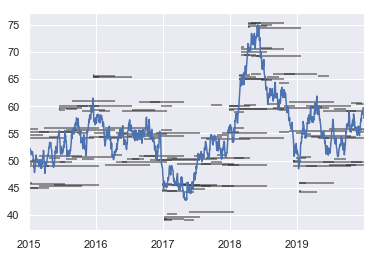

In [8]:
plot.plot_stock_and_options(gbm, options)

In [9]:
df_call = cm.get_hedge_df(
    options,
    interate_rate=SHORT_RATE,
    dt=DT,
    offset_bday=OFFSET_BDAYS,
    heston_type=False,
    display=False)


In [10]:
vix_path = creat_vix(X0, INDEX_START_DATE, INDEX_END_DATE)
df_call = df_call.join(vix_path, on='date')

This cell uses the Black-Scholes formula to calculate current option price $V0$, next option price $V1$, current delta $\delta$ and gamma $\gamma$.

In [11]:
# append implied vol, which is known constant to us.
df_call['implvol0'] = VOLATILITY
df_call['implvol1'] = VOLATILITY

df_call = bs.calc_call_price(df_call, colname_suf='0', vol=VOLATILITY)
df_call = bs.calc_call_price(df_call, colname_suf='1', vol=VOLATILITY)
df_call = bs.calc_call_delta(df_call, vol=VOLATILITY)
df_call = bs.calc_vega(df_call, vol=VOLATILITY)
# df_call = bs.calc_gamma(df_call, vol=VOLATILITY)

KeyError: 'S0_n'

In [ ]:
df_put = df_call.copy()

# First, convert price, then convert delta. Gamma and vega are the same.
df_put['V0'] = df_call['V0'] - df_call['S0'] + df_call['K'] * np.exp(-1 * SHORT_RATE * df_call['tau0'])
df_put['V1'] = df_call['V1'] - df_call['S1'] + df_call['K'] * np.exp(-1 * SHORT_RATE * df_call['tau1'])

df_put['delta_bs'] = df_call['delta_bs'] - 1

Here, we normalize prices (possibly including option prices and stock prices). The calculation is given by
$$
\frac{col}{C_{\rm NORM} * S0}
$$

In [ ]:
df_call = cm.normalize_prices(
    df_call,
    s_divisor=df_call['S0'],
    c_factor=C_NORM,
    cols=['S0', 'S1', 'V0', 'V1', 'vega'])

df_put = cm.normalize_prices(
    df_put,
    s_divisor=df_put['S0'],
    c_factor=C_NORM,
    cols=['S0', 'S1', 'V0', 'V1', 'vega']
)

In [13]:
df_call = make_features(df_call)
df_put = make_features(df_put)

Then, an integer flag for option type is added. Samples with option price less than threshold are removed.

In [14]:
total_call, total_put = df_call.shape[0], df_put.shape[0]

In [15]:
df_call, removal_rate_call, num_rem_call = bs.clean(df_call, 'OC', THRESHOLD_REMOVE_DATA)

df_put, removal_rate_put, num_rem_put = bs.clean(df_put, 'OP', THRESHOLD_REMOVE_DATA)

In [16]:
df_both = df_call.append(df_put, ignore_index=True)
df_train, df_val = cm.split_sim_data(df_both, 'date', pd.Timestamp(DATE_BREAK), OFFSET_BDAYS)
df_train.loc[:, 'period0'] = 0
df_val.loc[:, 'period0'] = 1
df_both = df_train.append(df_val, ignore_index=True)

In [17]:
sub_dir = DATA_DIR + 'CleanData/'
os.makedirs(sub_dir, exist_ok=True)
df_both.to_csv(sub_dir + 'train_val_sim.csv')

In [18]:
train_size, val_size = df_train.shape[0], df_val.shape[0]

# Generate Monte Carlo test sets
As before, we generate a set of options on each Monte Carlo set. Each of the set gives a dataframe in the way as above.

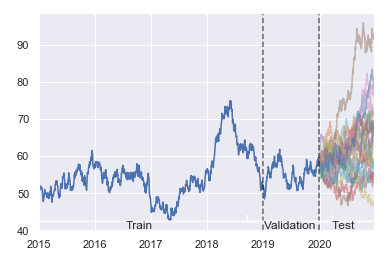

In [19]:
plot.plot_stock_test_prices(
    gbm,
    bs.GeometricBrownianMotion,
    N_ofTestDays,
    DATE_BREAK,
    INDEX_END_DATE)

In [20]:
init_test_value = gbm.get_instrument_values_as_df()['S0'].values[-1]
init_vix_value = vix_path.iloc[-1]

In [21]:
test_start_date = INDEX_END_DATE + BDay(OFFSET_BDAYS)
test_end_date = INDEX_END_DATE + BDay(N_ofTestDays + OFFSET_BDAYS)

gbm_test = bs.GeometricBrownianMotion(
    name='gbm_test',
    initial_value=init_test_value,
    volatility=VOLATILITY,
    annual_return=ANNUAL_RETURN,
    start_date=test_start_date,
    end_date=test_end_date
)


In [22]:
sub_dir = DATA_DIR + 'CleanData/MC/'
os.makedirs(sub_dir, exist_ok=True)

In [23]:
test_sizes = []

In [24]:
for i in range(NUM_TEST):
    options = cm.find_option_seq_jan_cycle(
        gbm_test, 
        start=test_start_date, 
        step_K=STEP_K, 
        threshold=THRESHOLD_OPTION_GENERATION,
        refresh=True)
    df_call = cm.get_hedge_df(
        options,
        interate_rate=SHORT_RATE,
        dt=DT,
        offset_bday=OFFSET_BDAYS,
        heston_type=False,
        display=False)
    
    # append volatility
    df_call['implvol0'] = VOLATILITY
    df_call['implvol1'] = VOLATILITY

    df_call = bs.calc_call_price(df_call, colname_suf='0', vol=VOLATILITY)
    df_call = bs.calc_call_price(df_call, colname_suf='1', vol=VOLATILITY)
    df_call = bs.calc_call_delta(df_call, vol=VOLATILITY)
    df_call = bs.calc_vega(df_call, vol=VOLATILITY)
    df_call = bs.calc_gamma(df_call, vol=VOLATILITY)
    
    vix_path = creat_vix(init_vix_value, test_start_date, test_end_date, refresh=True)
    df_call = df_call.join(vix_path, on='date')
    
    df_put = df_call.copy()
    df_put['V0'] = df_call['V0'] - df_call['S0'] + df_call['K'] * np.exp(-1 * SHORT_RATE * df_call['tau0'])
    df_put['V1'] = df_call['V1'] - df_call['S1'] + df_call['K'] * np.exp(-1 * SHORT_RATE * df_call['tau1'])
    df_put['delta_bs'] = df_call['delta_bs'] - 1
    
    df_call = cm.normalize_prices(
        df_call,
        s_divisor=df_call['S0'],
        c_factor=C_NORM,
        cols=['S0', 'S1', 'V0', 'V1'])
    df_put = cm.normalize_prices(
        df_put,
        s_divisor=df_put['S0'],
        c_factor=C_NORM,
        cols=['S0', 'S1', 'V0', 'V1']
    )
    
    df_call = make_features(df_call)
    df_put = make_features(df_put)
    
    df_call, _, _1 = bs.clean(df_call, 'OC', THRESHOLD_REMOVE_DATA)
    df_put, _1, _2 = bs.clean(df_put, 'OP', THRESHOLD_REMOVE_DATA)
    
    df_both = df_call.append(df_put, ignore_index=True)
    df_both.loc[:, 'period0'] = 2
    test_sizes.append(df_both.shape[0])
    
    df_both.to_csv(sub_dir + 'mc{}.csv'.format(i))

In [26]:
with open(f'{DATA_DIR}CleanData/paras.txt', 'w+') as file:
    for n, x in [
        ('Date and time', datetime.datetime.now()),
    	('Random seed', RANDOM_SEED),
    	('Hedging frequency', OFFSET_BDAYS),
    	('Normalized price', C_NORM),
    	('Training start date', OPTION_START_DATE),
        ('Initial total samples', total_call + total_put),
        ('The number of calls samples removed in training and val, due to threshold', num_rem_call),
        ('The number of puts samples removed in training and val, due to threshold', num_rem_put),
    	('Final training set size', train_size),
    	('Validation start date', DATE_BREAK),
    	('Validation set size', val_size),
    	('Test start date', test_start_date),
    	('Test end date', test_end_date),
    	('Test set AVERAGE size for both', sum(test_sizes) / NUM_TEST)
    ]:
        file.write(f'{n} = {x}\n')
